In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate, add, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
import os
import glob
import rasterio

import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def conv_block(x, filters, batchnorm=True):
    conv1 = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Activation('relu')(conv1)    
    conv2 = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Activation("relu")(conv2)

    return conv2

In [4]:
def residual_conv_block(x, filters, batchnorm=True):
    conv1 = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Activation('relu')(conv1)    
    conv2 = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Activation("relu")(conv2)
        
    #skip connection    
    shortcut = Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = BatchNormalization(axis=3)(shortcut)
    shortcut = Activation("relu")(shortcut)
    respath = add([shortcut, conv2])       
    return respath

In [5]:
def dense_block(inputs, num_filters):
    conv1 = conv_block(inputs, num_filters)
    concat = Concatenate()([inputs, conv1])
    return concat

In [6]:
def residual_unet(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = residual_conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = residual_conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = residual_conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = residual_conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), kernel_initializer='he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    up6 = Concatenate()([up6, conv4])
    conv6 = residual_conv_block(up6, 512)
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = Concatenate()([up7, conv3])
    conv7 = residual_conv_block(up7, 256)
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = Concatenate()([up8, conv2])
    conv8 = residual_conv_block(up8, 128)
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = Concatenate()([up9, conv1])
    conv9 = residual_conv_block(up9, 64)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
def dense_unet(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = dense_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = dense_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = dense_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = dense_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), kernel_initializer='he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    up6 = Concatenate()([up6, conv4])
    conv6 = residual_conv_block(up6, 512)
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = Concatenate()([up7, conv3])
    conv7 = residual_conv_block(up7, 256)
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = Concatenate()([up8, conv2])
    conv8 = residual_conv_block(up8, 128)
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = Concatenate()([up9, conv1])
    conv9 = residual_conv_block(up9, 64)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
def load_data(input_dir, mask_dir):
    input_files = sorted(glob.glob(os.path.join(input_dir, '*.tif')))
    # print(input_files)
    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))
    # print(mask_files)
    images = []
    masks = []

    for input_file, mask_file in zip(input_files, mask_files):
        # Read input file
        with rasterio.open(input_file) as src:
            img = src.read(1)  # Read the first band assuming it's a single-band image
            # print(img)
            images.append(img)

        # Read mask file
        with rasterio.open(mask_file) as src:
            msk = src.read(1)  # Read the first band assuming it's a single-band image
            masks.append(msk)

    # print(np.array(masks)/255)
    return np.array(images), np.array(masks)/255

In [9]:
input_dir = './data_new/'
mask_dir = './output_tif/'

# Load data
images, masks = load_data(input_dir, mask_dir)

# Define input shape and number of classes
images = np.expand_dims(images, axis=-1)
input_shape = images.shape[1:]

# images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Create and compile the model

# for layer in model.layers:
#     print(layer.output_shape)

In [10]:
model = dense_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
model.fit(images, masks, validation_split=0.1, epochs=10, batch_size=2)  # Adjust epochs and batch size as needed
model.save('UNet_dense_10_epoch.h5')

Epoch 1/10
299/568 [==============>...............] - ETA: 2:30 - loss: 0.5615 - accuracy: 0.7373

KeyboardInterrupt: 

1/1 [==============================] - 0s 261ms/step


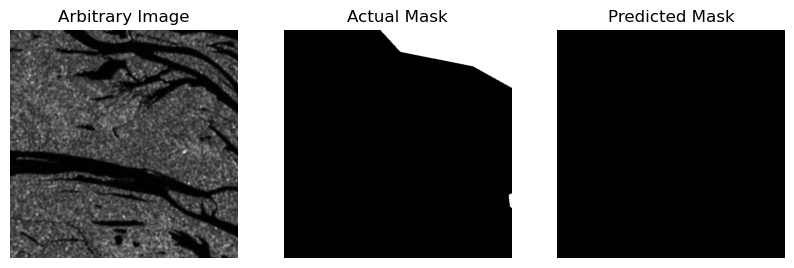

1/1 [==============================] - 0s 20ms/step


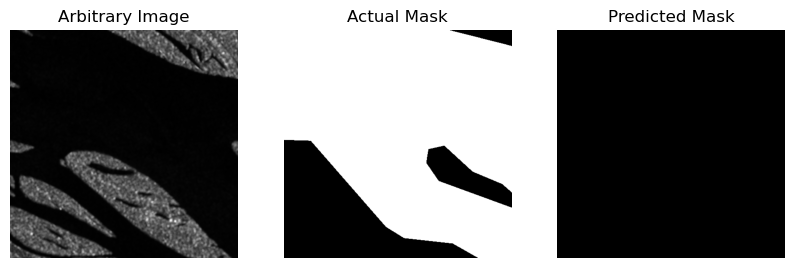

1/1 [==============================] - 0s 10ms/step


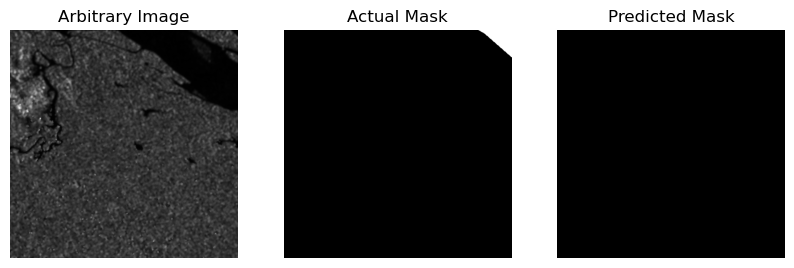

1/1 [==============================] - 0s 20ms/step


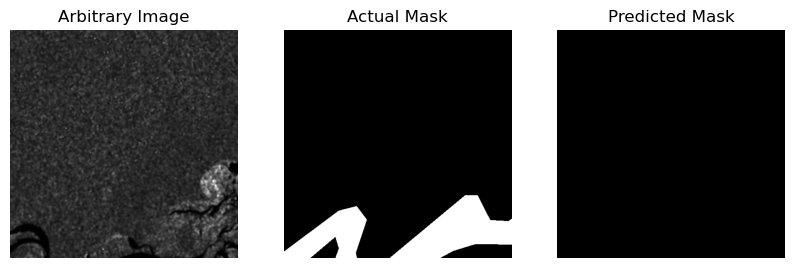

1/1 [==============================] - 0s 20ms/step


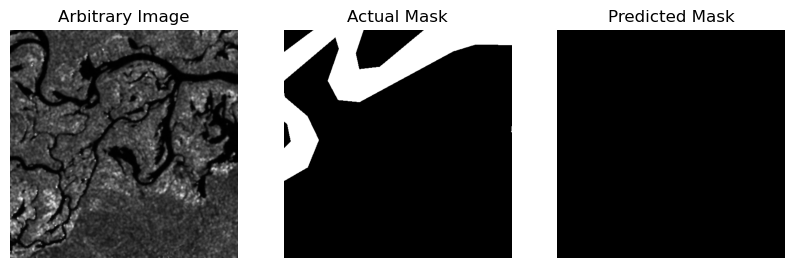

1/1 [==============================] - 0s 10ms/step


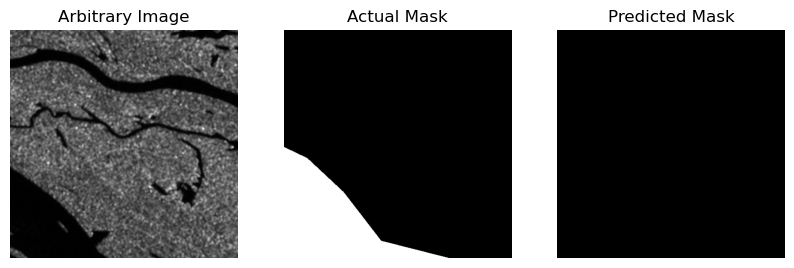

1/1 [==============================] - 0s 20ms/step


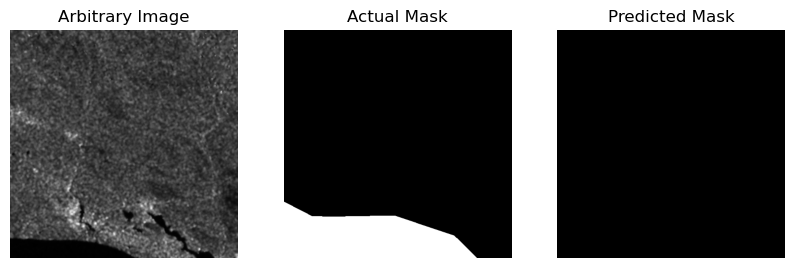

1/1 [==============================] - 0s 20ms/step


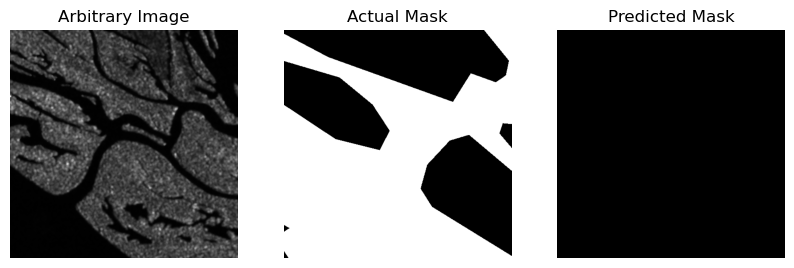

1/1 [==============================] - 0s 10ms/step


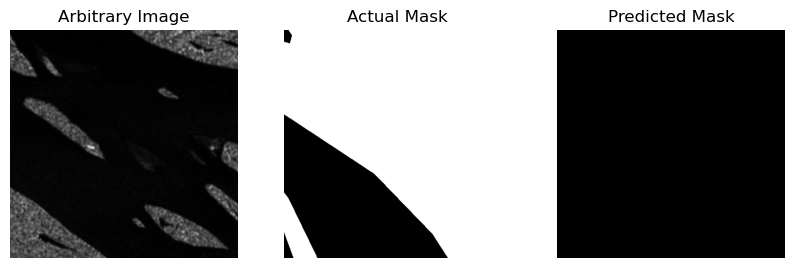

1/1 [==============================] - 0s 20ms/step


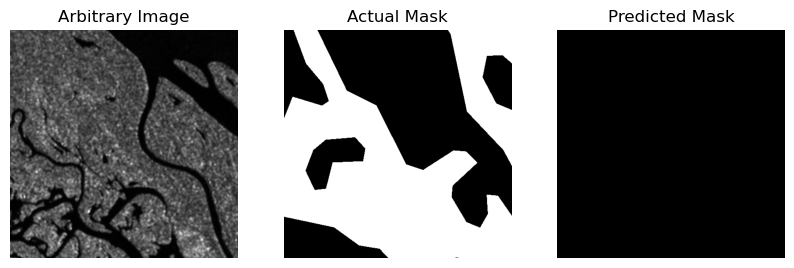

In [ ]:
i=0
for arbitrary_img, arbitrary_mask in zip(images, masks):

# arbitrary_image_path = 'data_new\subset_0_of_subset_1_of_final_S1A_IW_GRDH_1SDV_20240109T095534_20240109T095559_052028_06499B_56C7_0_1024.tif'
# arbitrary_image_mask = 'output_tif\subset_0_of_subset_1_of_final_S1A_IW_GRDH_1SDV_20240109T095534_20240109T095559_052028_06499B_56C7_0_1024_new_mask.tif'

# # Read the arbitrary image
# with rasterio.open(arbitrary_image_path) as src:
#     arbitrary_img = src.read(1)  # Read the first band assuming it's a single-band image

# with rasterio.open(arbitrary_image_mask) as src:
#     arbitrary_mask = src.read(1)

# Preprocess the arbitrary image if necessary (e.g., normalize, resize) to match the input dimensions of your model
# ...

    predicted_mask = model.predict(np.expand_dims(arbitrary_img, axis=0))[0]

    # Threshold the predicted mask if necessary
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Plot the arbitrary image and the predicted mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(arbitrary_img, cmap='gray')
    plt.title('Arbitrary Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(arbitrary_mask, cmap='gray')
    plt.title('Actual Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.savefig(f"./outputs_diva_gis/dense_{i}.jpg")
    plt.show()
    i+=1

    if (i==10):
        break

In [ ]:
model = residual_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
model.fit(images, masks, validation_split=0.1, epochs=10, batch_size=2)
model.save('UNet_residual_10_epoch.h5')

Epoch 1/10


ResourceExhaustedError: Graph execution error:

Detected at node 'model_4/batch_normalization_106/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\ADMIN\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\ADMIN\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\ADMIN\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\ADMIN\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\ADMIN\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_52552\3281818721.py", line 7, in <module>
      model.fit(images, masks, validation_split=0.1, epochs=10, batch_size=2)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\ADMIN\anaconda3\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_4/batch_normalization_106/FusedBatchNormV3'
OOM when allocating tensor with shape[2,64,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_4/batch_normalization_106/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_274141]

In [ ]:
i=0
for arbitrary_img, arbitrary_mask in zip(images, masks):

    predicted_mask = model.predict(np.expand_dims(arbitrary_img, axis=0))[0]

    # Threshold the predicted mask if necessary
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Plot the arbitrary image and the predicted mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(arbitrary_img, cmap='gray')
    plt.title('Arbitrary Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(arbitrary_mask, cmap='gray')
    plt.title('Actual Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.savefig(f"./outputs_diva_gis/residual_{i}.jpg")
    plt.show()
    i+=1

    if (i==10):
        break